In [6]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

# 1.1

In [7]:
sst_Data = xr.open_dataset('NOAA_NCDC_ERSST_v3b_SST.nc')
sst_region = sst_Data.sel(lat=slice(-5,5), lon=slice(190,240))

In [ ]:

group_data = sst_region.sst.groupby('time.month')
sst_anm = group_data - group_data.mean(dim='time')

sst_anm.values

# 1.2

In [11]:
sst_anm_rolling = sst_anm.rolling(time=3, center=True).mean()
line_anm = np.nanmean(sst_anm_rolling.values,axis=(1,2))

C:\Users\ZHAOANG\AppData\Local\Temp/ipykernel_6268/2672718069.py:2: RuntimeWarning: Mean of empty slice
  line_anm = np.nanmean(sst_anm_rolling.values,axis=(1,2))


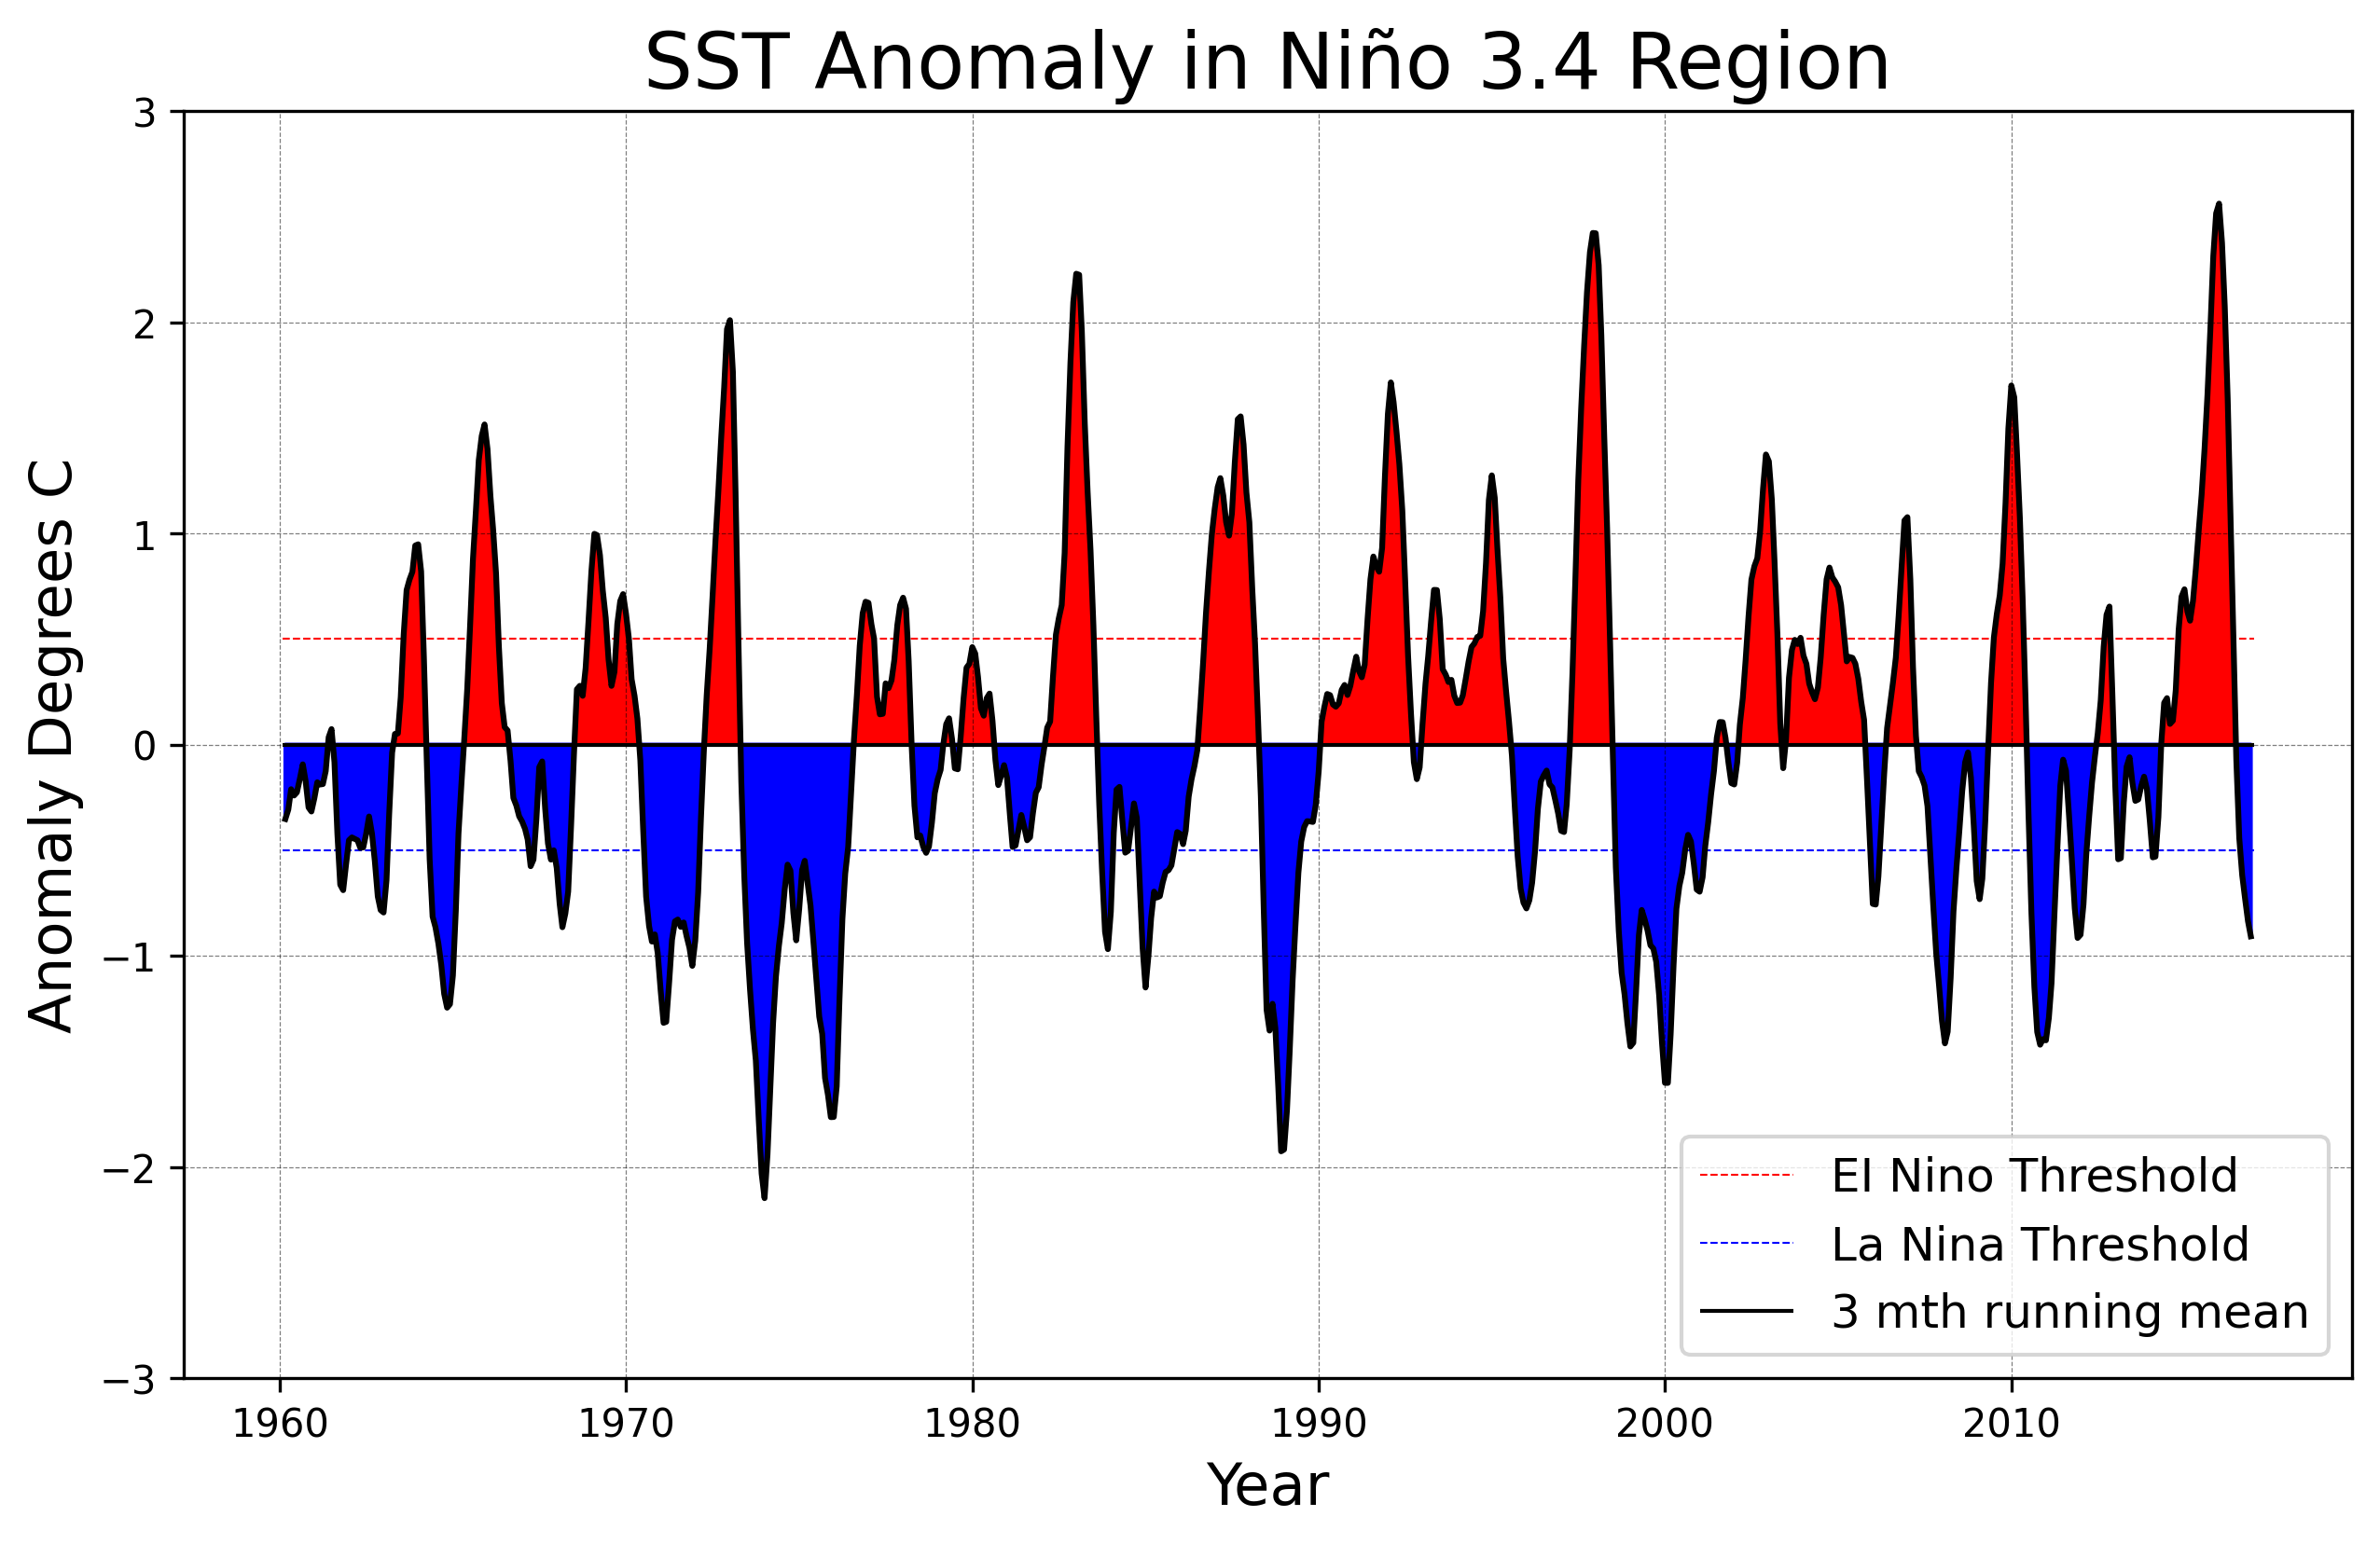

In [12]:
# plot
# set time serious
time = pd.date_range(start='1960-01',periods=684,freq='m')
fig,ax = plt.subplots(1,1,figsize = [10,6],dpi=300)

# put time and anomaly into the figure
ax.plot(time,line_anm,color='k')

# set xlabel, ylabel and title
ax.set_ylabel('Anomaly Degrees C', color='k', fontsize=15)
ax.set_xlabel('Year', color='k', fontsize=15)
ax.set_title("SST Anomaly in Niño 3.4 Region", fontsize=20)

# Plot grid lines
ax.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')

# put hlines into the figure
ax.hlines(y = 0.5,xmin=time[0],xmax=time[-1],color='r',linestyles='--',lw=0.5,label='EI Nino Threshold')
ax.hlines(y = -0.5,xmin=time[0],xmax=time[-1],color='b',linestyles='--',lw=0.5,label='La Nina Threshold')
ax.hlines(y = 0,xmin=time[0],xmax=time[-1],color='k',linestyles='solid',lw=1,label='3 mth running mean')

# set ylabel limitation
ax.set_ylim(-3,3)

# put legend into the figure
ax.legend(loc='best',fontsize=12)

# fill different color into the figure
ax.fill_between(time,0,line_anm,where=(line_anm>0),color='r')
ax.fill_between(time,0,line_anm,where=(line_anm<0),color='b')

# 2

In [23]:
ds_toa=xr.open_dataset('CERES_EBAF-TOA_200003-201701.nc')
da_lw=ds_toa['toa_lw_all_mon']
da_sw=ds_toa['toa_sw_all_mon']
da_sr=ds_toa['solar_mon']
da_nf=ds_toa['toa_net_all_mon']
time=ds_toa['time']

Text(0.5, 1.0, 'net flux')

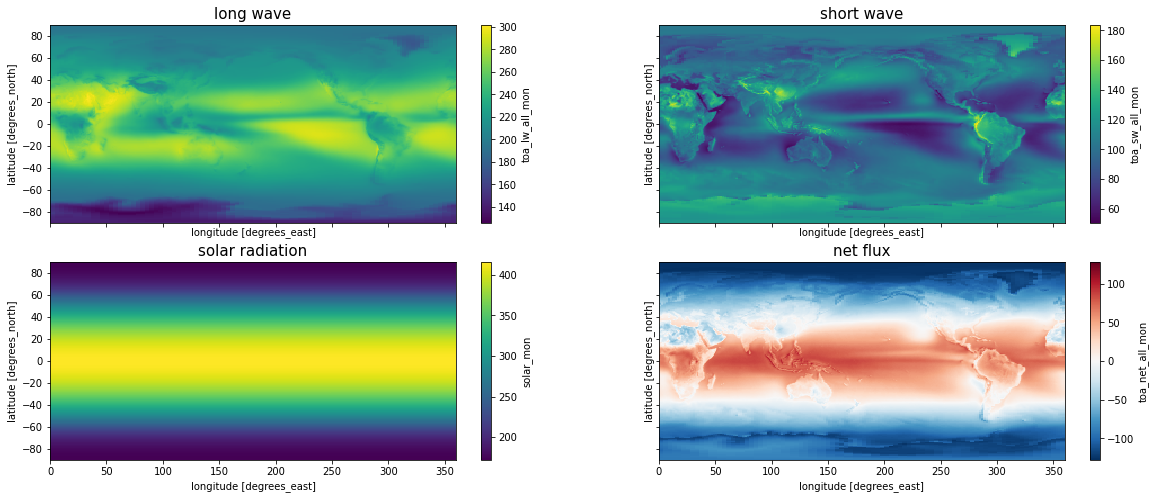

In [24]:
fig,axs=plt.subplots(2,2,sharex=True,sharey=True,figsize=(20,8))
da_lw.mean(dim='time').plot(ax=axs[0,0])
da_sw.mean(dim='time').plot(ax=axs[0,1])
da_sr.mean(dim='time').plot(ax=axs[1,0])
da_nf.mean(dim='time').plot(ax=axs[1,1])

axs[0,0].set_title('long wave',fontsize=15)
axs[0,1].set_title('short wave',fontsize=15)
axs[1,0].set_title('solar radiation',fontsize=15)
axs[1,1].set_title('net flux',fontsize=15)

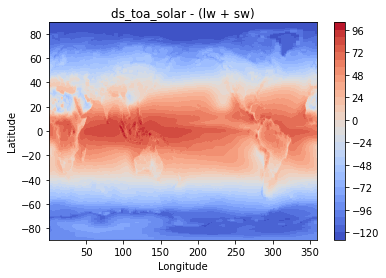

In [43]:
fig, ax = plt.subplots(1,1)
x = ds_toa.toa_sw_all_mon.lon
y = ds_toa.toa_sw_all_mon.lat
z = ds_toa.solar_mon.mean(dim='time') - (ds_toa.toa_lw_all_mon.mean(dim='time') + ds_toa.toa_sw_all_mon.mean(dim='time'))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('ds_toa_solar - (lw + sw)')
cntr = ax.contourf(x, y, z, levels=30, cmap=cm.coolwarm)
fig.colorbar(cntr, ax=ax)
plt.show()


# 2.2

In [13]:
ds_toa=xr.open_dataset('CERES_EBAF-TOA_200003-201701.nc')
da_lw=ds_toa['toa_lw_all_mon']
da_sw=ds_toa['toa_sw_all_mon']
da_sr=ds_toa['solar_mon']
da_nf=ds_toa['toa_net_all_mon']

In [14]:
R=6371.4e3

lat_j=np.linspace(-89.5,89.5,180)
lat_j_rad=np.deg2rad(lat_j)

cos_j=np.cos(lat_j_rad)
Sj=2*np.pi**2*cos_j*R**2/(180*360)

Sij=np.repeat(Sj.reshape(-1,1),360,axis=1)
Stij=np.repeat(Sij.reshape(1,180,360),203,axis=0)

In [15]:
da_sr.values*=Stij
da_lw.values*=Stij
da_sw.values*=Stij

In [16]:
# the area of the whole surface of earth
area_glob=4*np.pi*R**2

sr=da_sr.mean(dim='time').values.sum()/area_glob
lw=da_lw.mean(dim='time').values.sum()/area_glob
sw=da_sw.mean(dim='time').values.sum()/area_glob

In [17]:
print('solar radiations (Wm-2):',sr.round(1))
print('long wave outgoing (Wm-2):',lw.round(1))
print('short wave outgoing (Wm-2):',sw.round(1))

solar radiations (Wm-2): 340.3
long wave outgoing (Wm-2): 240.3
short wave outgoing (Wm-2): 99.1


# 2.3

In [19]:
da_nf=ds_toa['toa_net_all_mon']
da_nf.values*=Stij/1e9

Text(0.5, 1.0, 'Net radiation in each 1-degree latitude band $(10^9W)$')

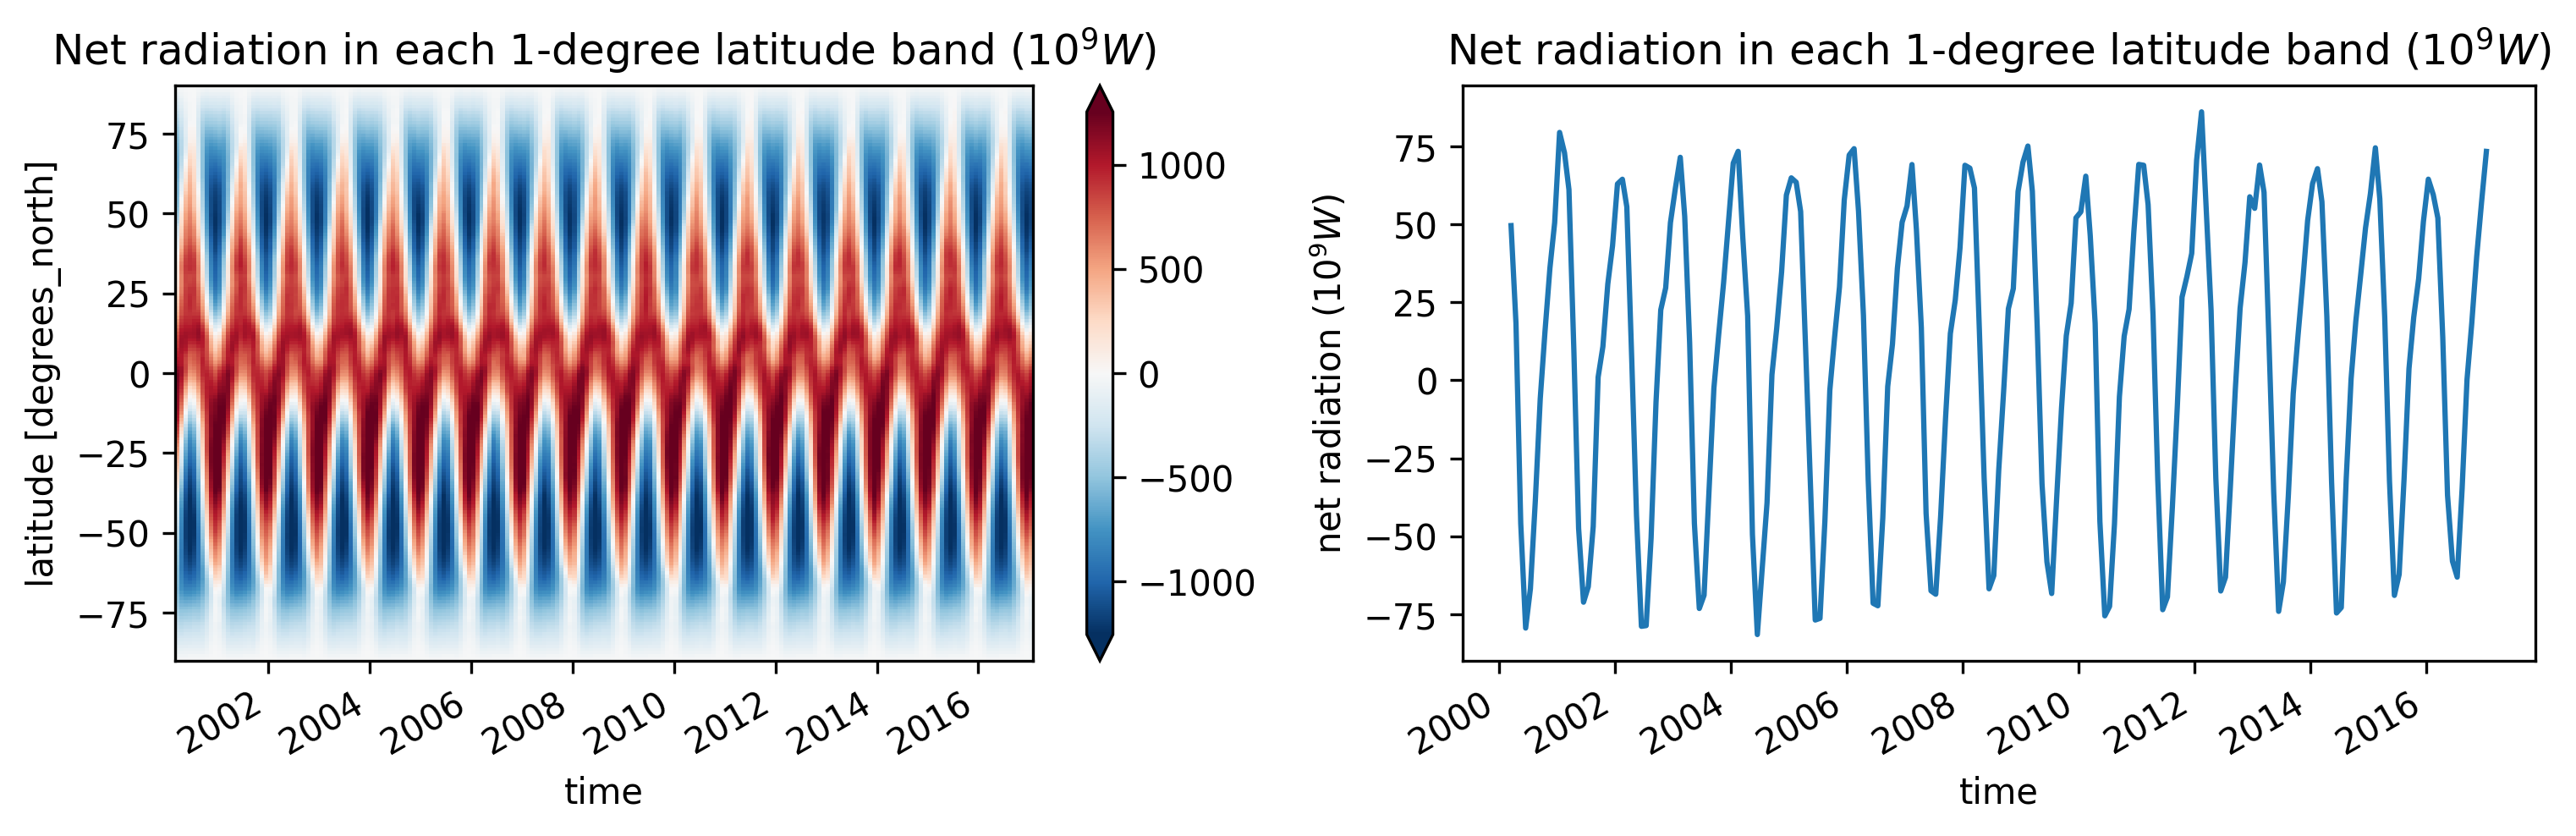

In [20]:
fig,axs=plt.subplots(1,2,figsize=(12,3),dpi=300)

da_nf.rename('').mean(dim='lon').transpose().plot(ax=axs[0],robust=True)
axs[0].set_title('Net radiation in each 1-degree latitude band $(10^9W)$')
da_nf.mean(dim={'lon','lat'}).plot(ax=axs[1])
axs[1].set_ylabel('net radiation $(10^9W)$')
axs[1].set_title('Net radiation in each 1-degree latitude band $(10^9W)$')

# 2.4

In [21]:
arrclda = ds_toa.cldarea_total_daynight_mon.mean(dim='time').values
high_cloud_area = (arrclda>=75)
low_cloud_area = (arrclda<=25)

In [23]:
hclw = ds_toa.toa_lw_all_mon.mean(dim='time')
hcsw = ds_toa.toa_sw_all_mon.mean(dim='time')
lclw = ds_toa.toa_lw_all_mon.mean(dim='time')
lcsw = ds_toa.toa_sw_all_mon.mean(dim='time')

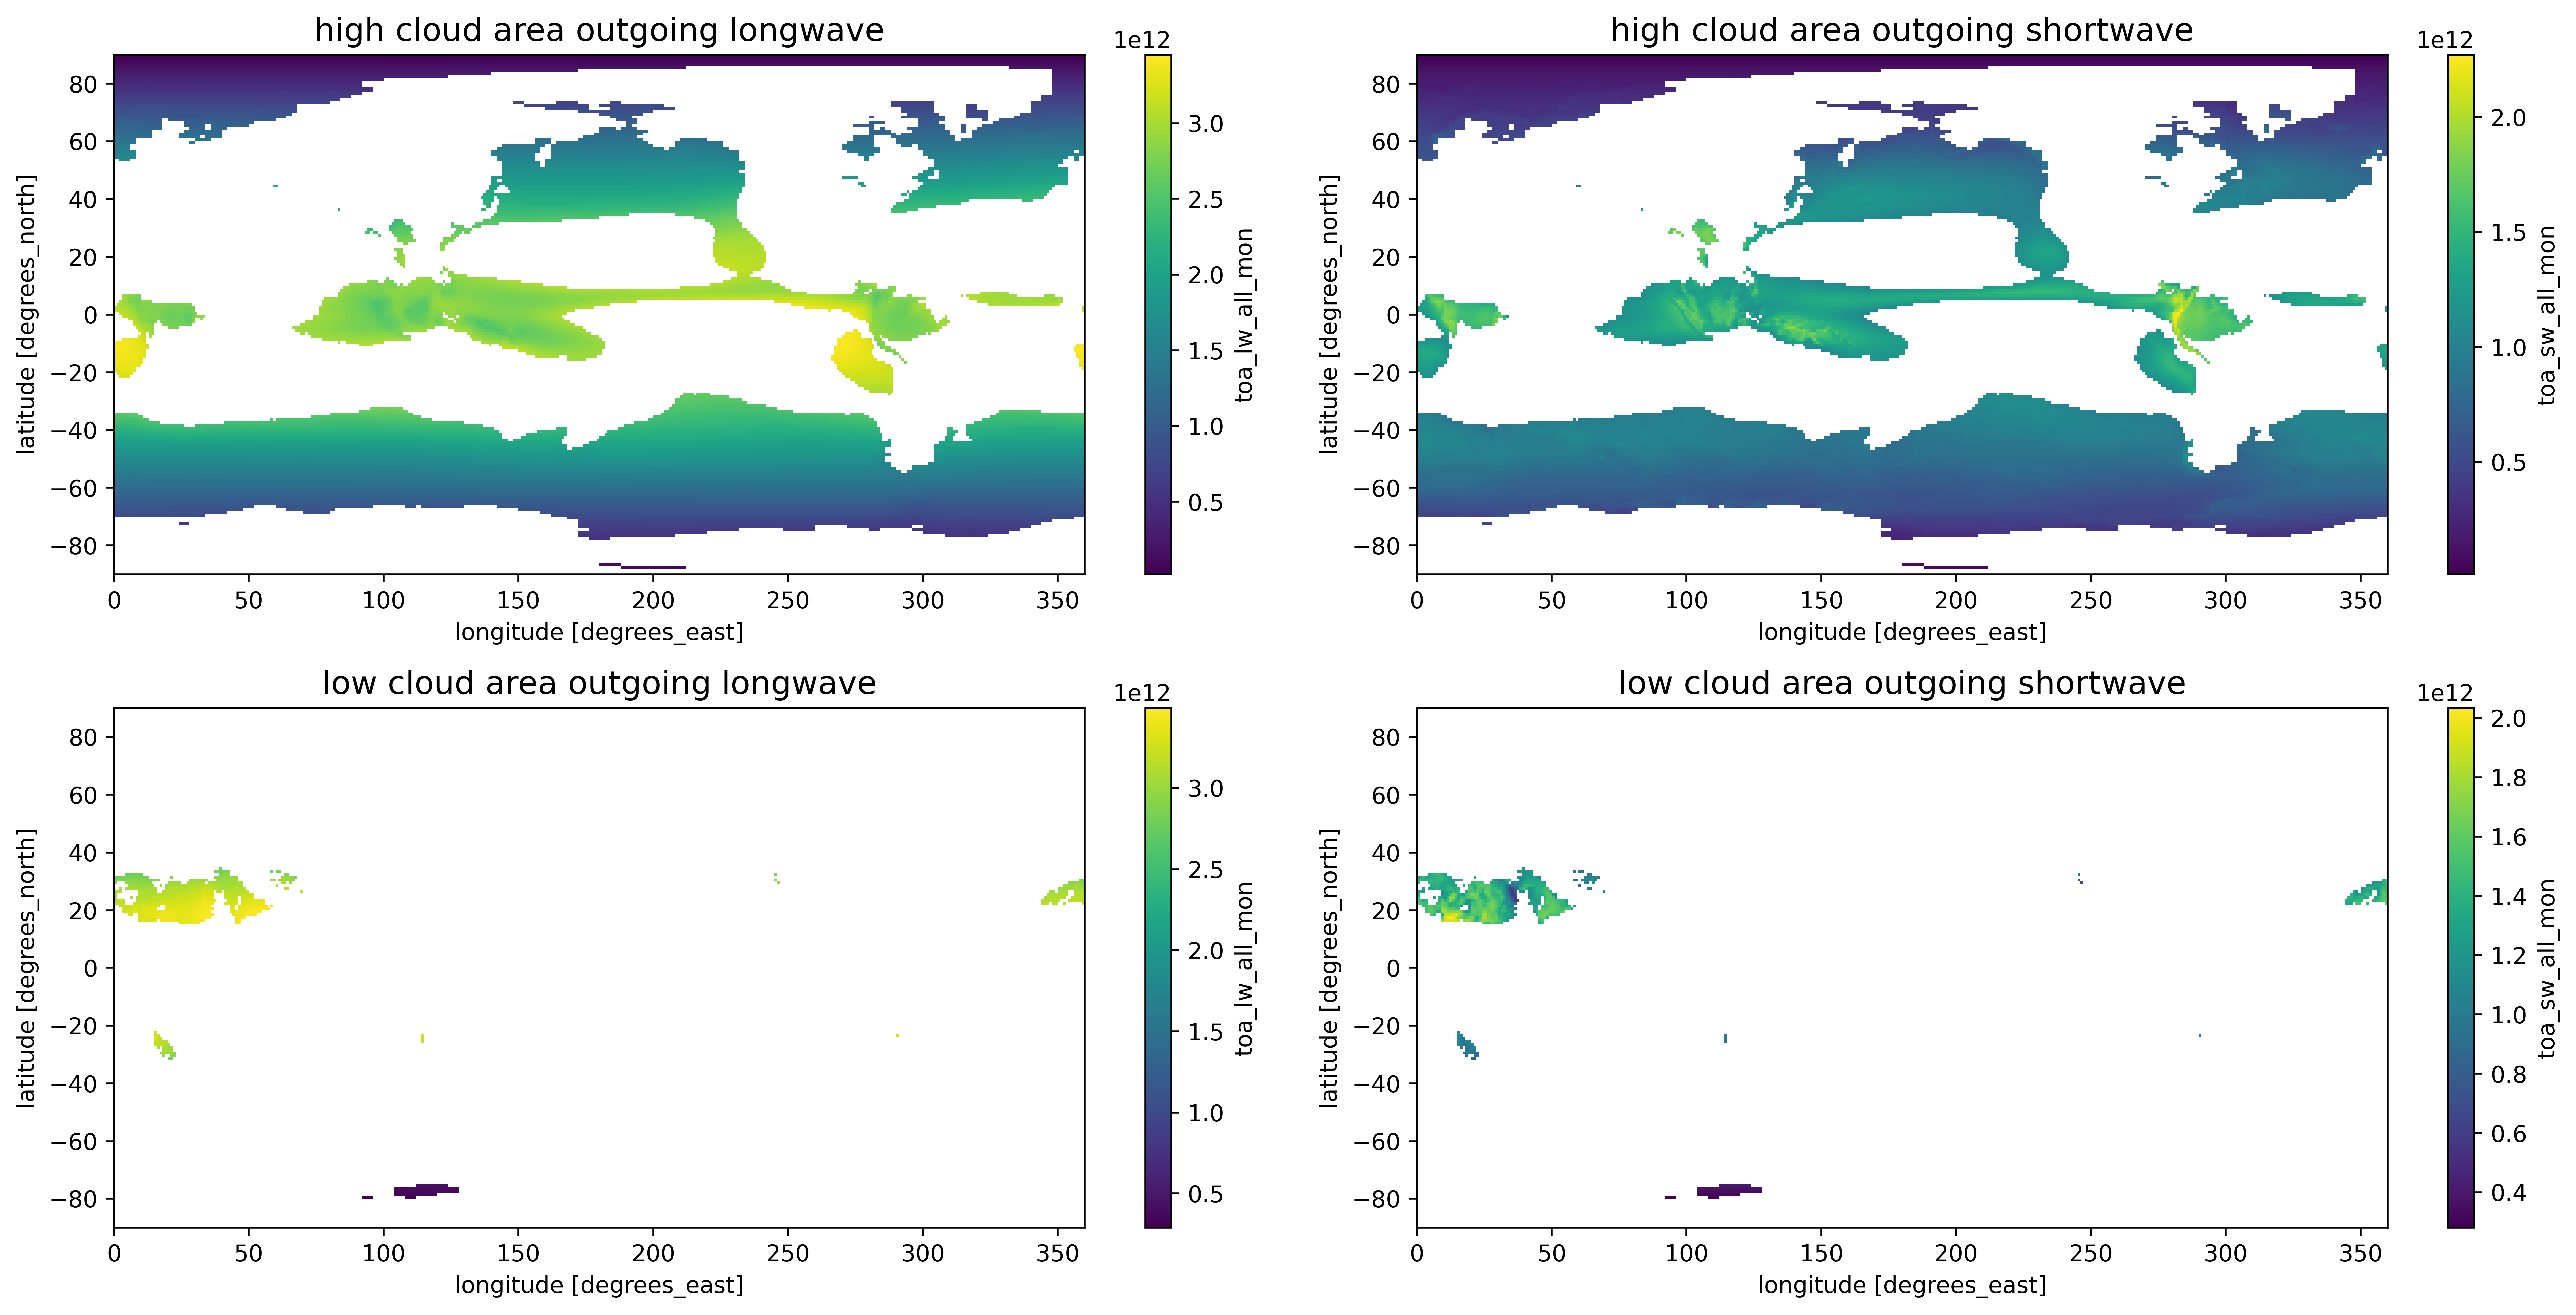

In [24]:
# Create Figure and Subplots
fig,axes = plt.subplots(2,2,figsize=(16,8),dpi=500)
# Plot each axes
hclw.where(high_cloud_area).plot(ax=axes[0,0])
hcsw.where(high_cloud_area).plot(ax=axes[0,1])
lclw.where(low_cloud_area).plot(ax=axes[1,0])
lcsw.where(low_cloud_area).plot(ax=axes[1,1])
axes[0,0].set_title('high cloud area outgoing longwave',fontsize = 14)
axes[0,1].set_title('high cloud area outgoing shortwave',fontsize = 14)
axes[1,0].set_title('low cloud area outgoing longwave',fontsize = 14)
axes[1,1].set_title('low cloud area outgoing shortwave',fontsize = 14)
plt.tight_layout()

# 2.5

In [26]:
print('high cloud long wave:',np.nanmean(hclw),'(W/m2)')
print('high cloud short wave:',np.nanmean(hcsw),'(W/m2)')
print('low cloud long wave:',np.nanmean(lclw),'(W/m2)')
print('low cloud short wave:',np.nanmean(lcsw),'(W/m2)')

high cloud long wave: 1891498600000.0 (W/m2)
high cloud short wave: 780467600000.0 (W/m2)
low cloud long wave: 1891498600000.0 (W/m2)
low cloud short wave: 780467600000.0 (W/m2)


# 3.1


In [27]:
ds = xr.open_dataset("air.sig995.2012.nc")

C:\Users\ZHAOANG\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\coding\times.py:119: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [28]:
group_data = ds.air.groupby('time.month')
air_anom = group_data - group_data.mean(dim='time')
line_air_anom = air_anom.mean(dim={'lat','lon'})

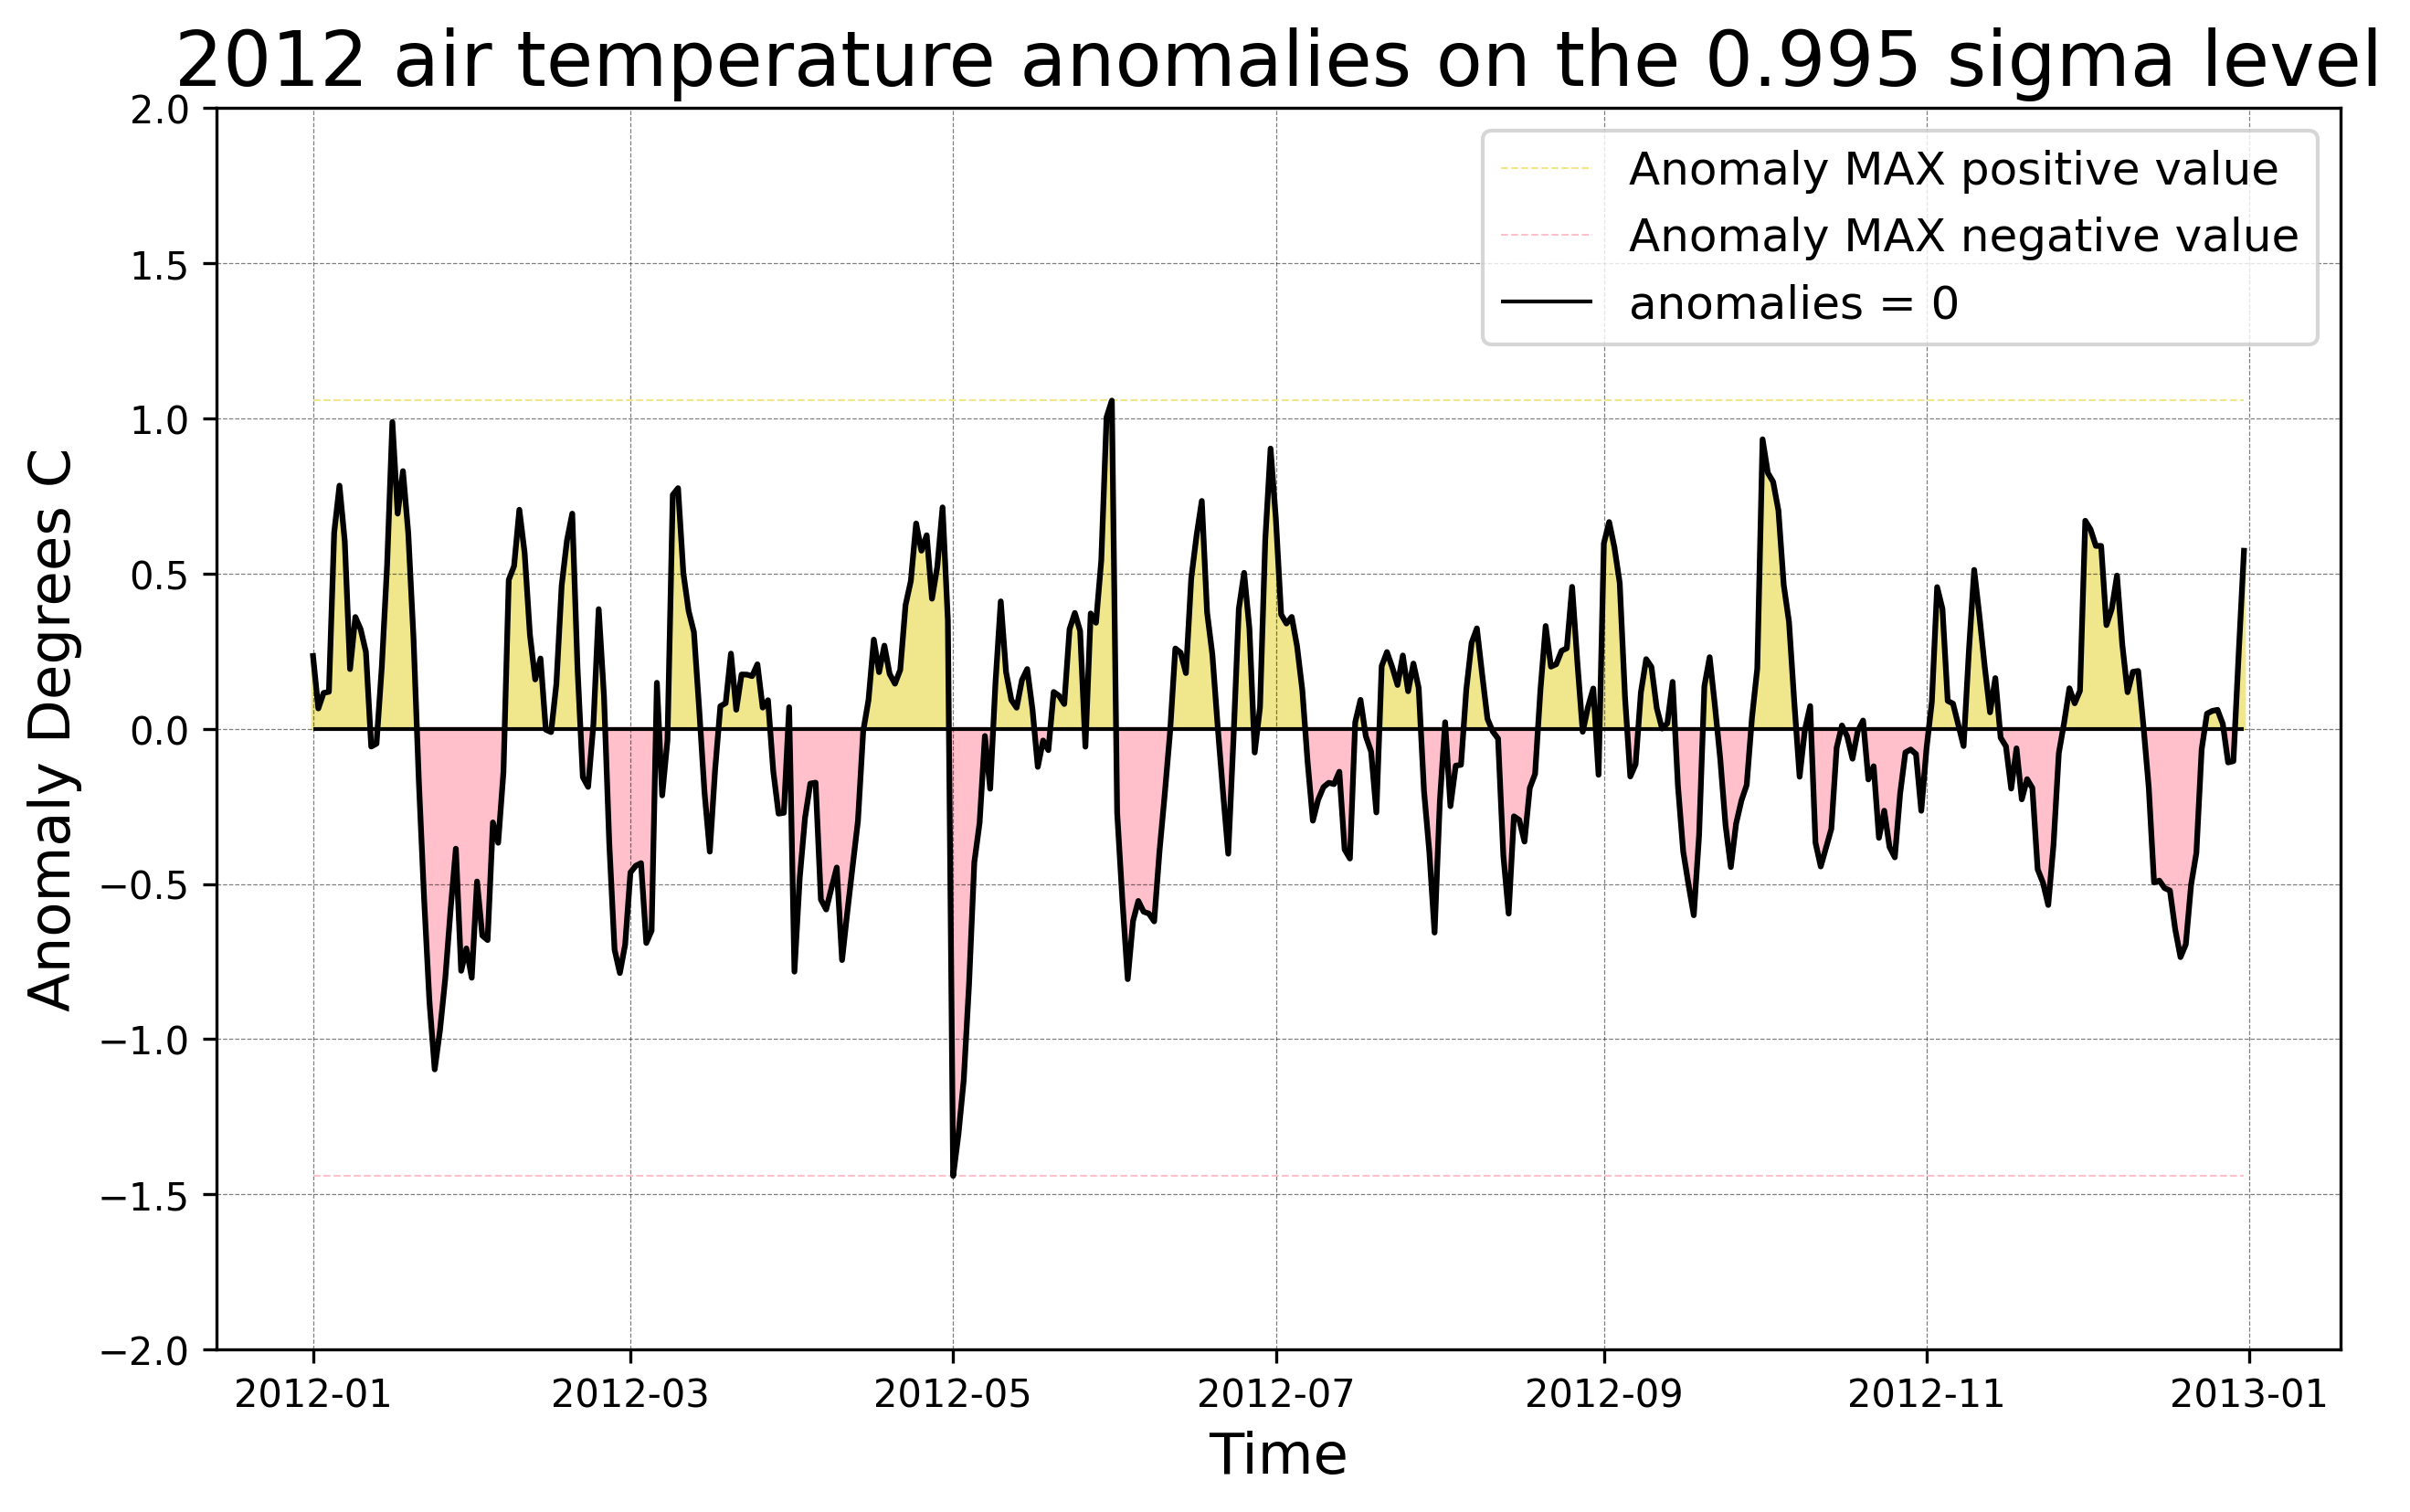

In [29]:
time = pd.date_range(start='2012-01-01',periods=366,freq='d')
fig,ax = plt.subplots(1,1,figsize = [10,6],dpi=300)

ax.plot(time,line_air_anom,color='k')

ax.set_ylabel('Anomaly Degrees C', color='k', fontsize=15)
ax.set_xlabel('Time', color='k', fontsize=15)
ax.set_title("2012 air temperature anomalies on the 0.995 sigma level", fontsize=20)


ax.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')

ax.hlines(y = line_air_anom.max(),xmin=time[0],xmax=time[-1],color='khaki',linestyles='--',lw=0.5,label='Anomaly MAX positive value')
ax.hlines(y = line_air_anom.min(),xmin=time[0],xmax=time[-1],color='pink',linestyles='--',lw=0.5,label='Anomaly MAX negative value')
ax.hlines(y = 0,xmin=time[0],xmax=time[-1],color='k',linestyles='solid',lw=1,label='anomalies = 0')

ax.set_ylim(-2,2)
ax.legend(loc='best',fontsize=12)

ax.fill_between(time,0,line_air_anom,where=(line_air_anom>0),color='khaki')
ax.fill_between(time,0,line_air_anom,where=(line_air_anom<0),color='pink')

# 3.2

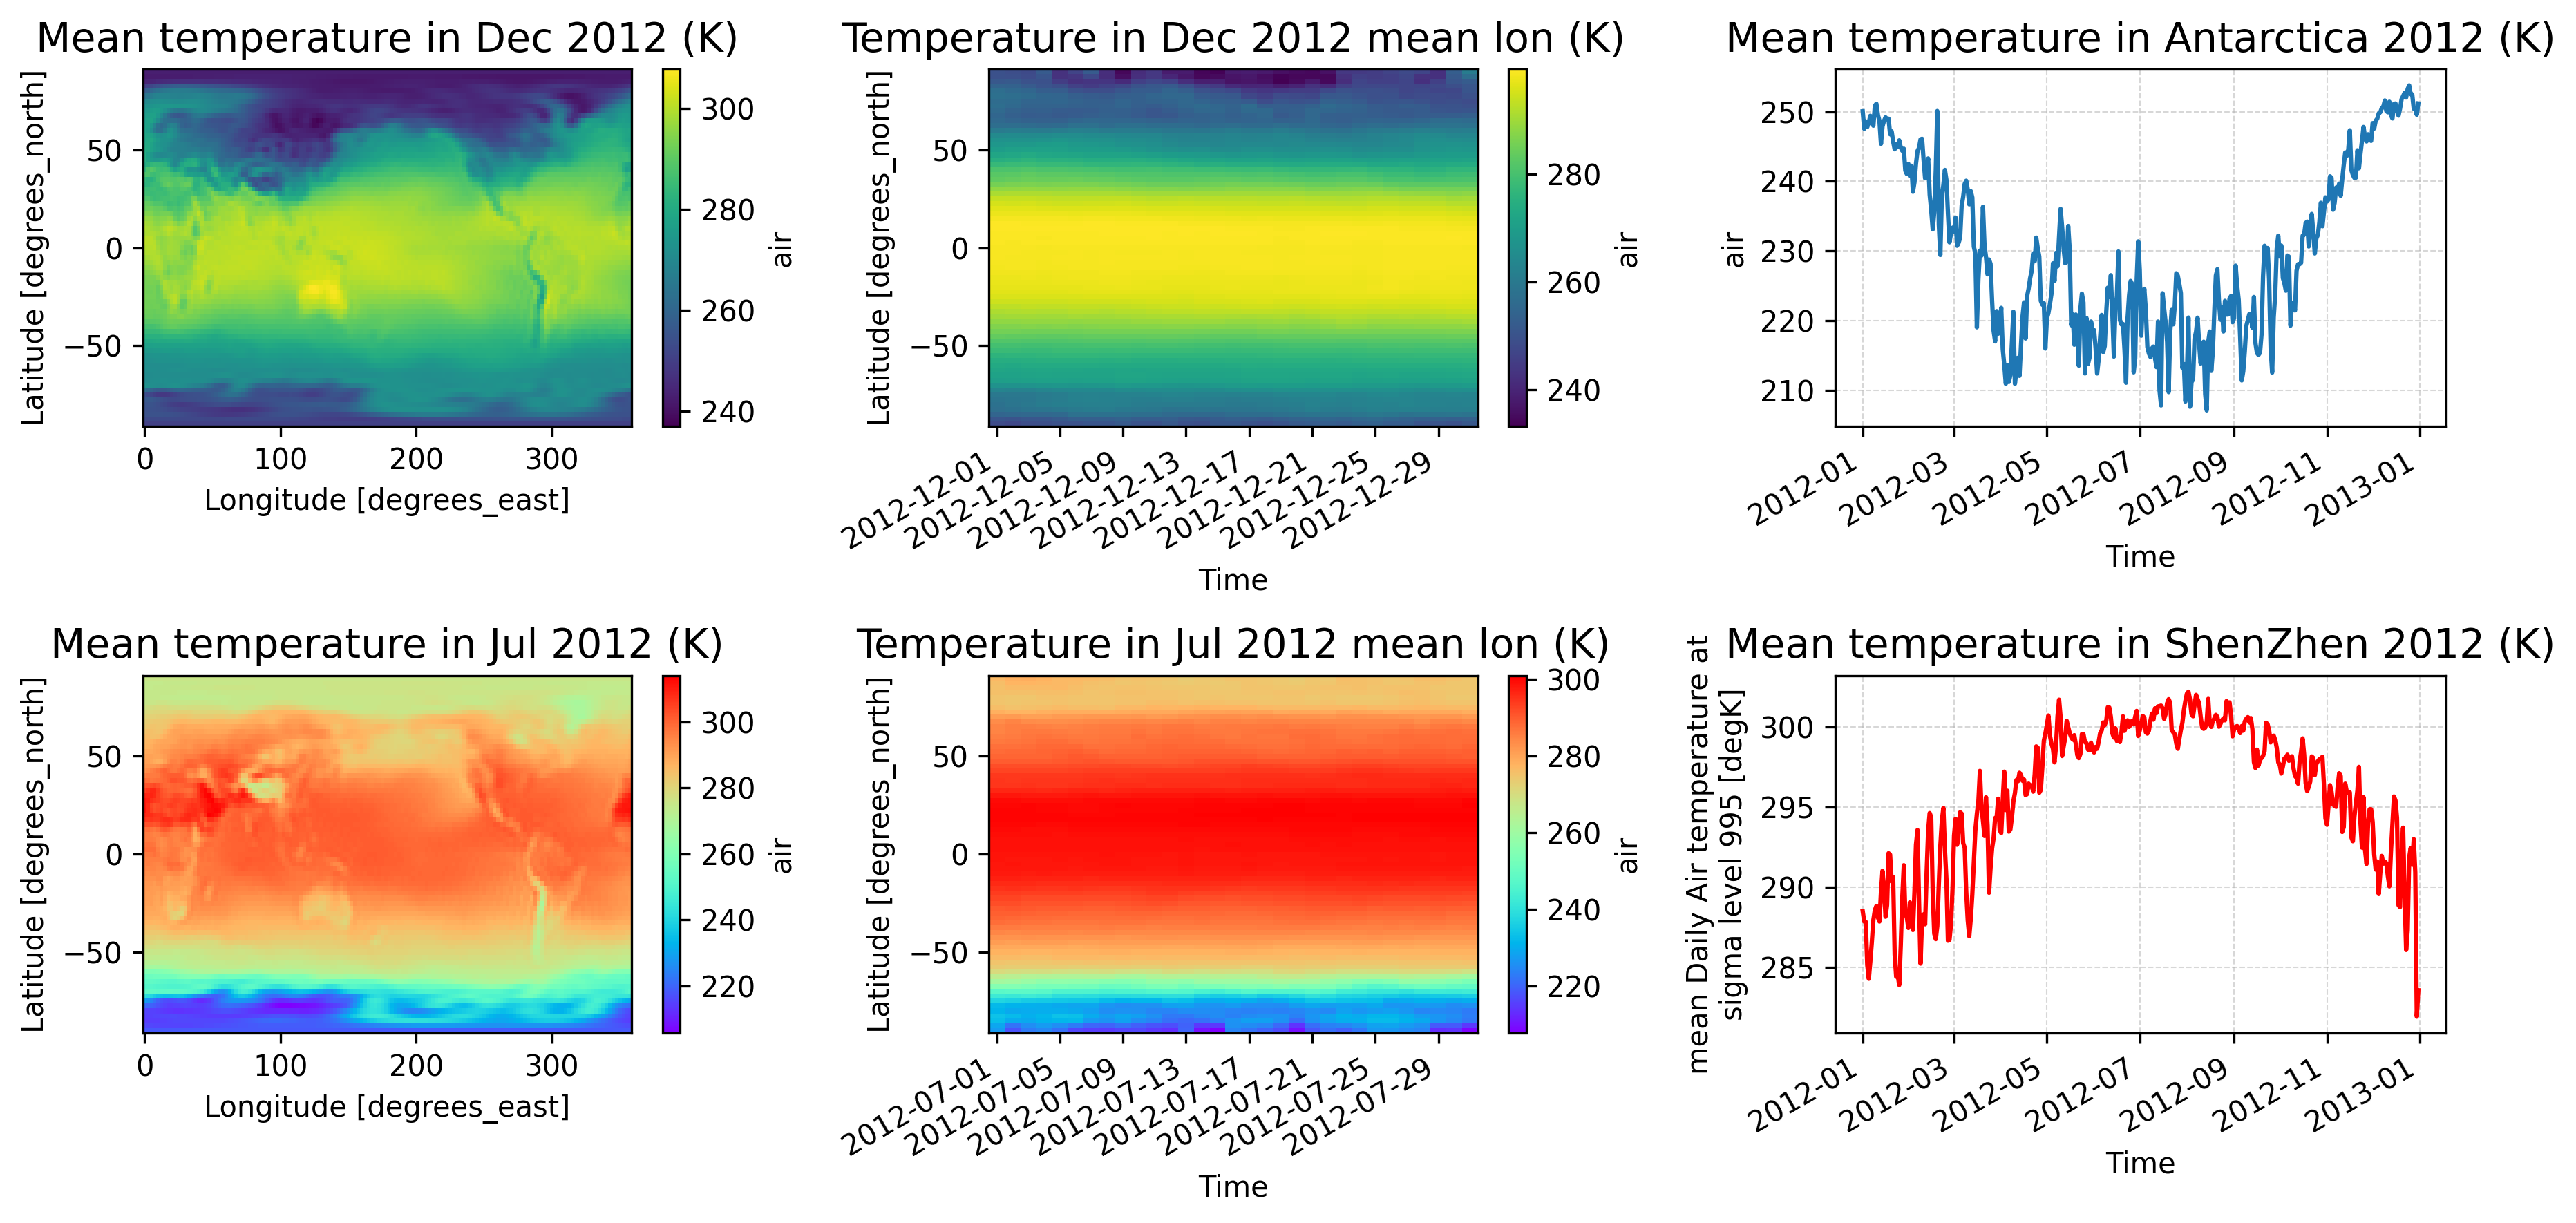

In [30]:
fig, axes = plt.subplots(2,3, figsize=(12,6), sharex=False, sharey=False, dpi=300)
da_air = ds.air
da_air_Dec = ds.air.sel(time=slice('2012-12-01', '2012-12-31'))
da_air_Jul = ds.air.sel(time=slice('2012-07-01','2012-07-31'))
da_air_shenzhen = ds.air.sel(lon='114',lat='22.5',method='nearest')
da_air_Ant = ds.air.sel(lat='-90',method='nearest')



da_air_Dec.mean('time').plot(ax=axes[0,0])
da_air_Jul.mean('time').plot(ax=axes[1,0],cmap='rainbow')
da_air_Dec.mean('lon').transpose().plot(ax=axes[0,1])
da_air_Jul.mean('lon').transpose().plot(ax=axes[1,1],cmap='rainbow')
da_air_shenzhen.plot(ax=axes[1,2],c='r')
da_air_Ant.mean('lon').plot(ax=axes[0,2])


axes[0,2].grid(linestyle='--', linewidth=0.5, alpha=0.5)
axes[1,2].grid(linestyle='--', linewidth=0.5, alpha=0.5)


axes[0,0].set_title('Mean temperature in Dec 2012 (K)',fontsize = 14)
axes[1,0].set_title('Mean temperature in Jul 2012 (K)',fontsize = 14)
axes[0,1].set_title('Temperature in Dec 2012 mean lon (K)',fontsize = 14)
axes[1,1].set_title('Temperature in Jul 2012 mean lon (K)',fontsize = 14)
axes[1,2].set_title('Mean temperature in ShenZhen 2012 (K)',fontsize = 14)
axes[0,2].set_title('Mean temperature in Antarctica 2012 (K)',fontsize = 14)

# better layout
plt.tight_layout()